# Assignment - Support Vector Machines

## Hndwritten Digit Recognition using SVM

In [1]:
# Importing the required libraries
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale

### Reading the data

In [2]:
digits_data = pd.read_csv("train.csv")
digits_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Dataset related information

In [3]:
# dimensions
print("Dimensions: ", digits_data.shape, "\n")

Dimensions:  (42000, 785) 



In [4]:
# Size of the dataset and the memory usage
digits_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


It can be seen that it's a large dataset. It has 42K rows and 785 columns. It is occupying ~250 MB.

In [5]:
# Checking the datatype of the label
print(digits_data.label.dtype)

int64


In [6]:
# Checking the datatype of the pixel columns and also making sure that the colums are of same datatype
pixDataType = digits_data.pixel0.dtype
print(pixDataType)
for col in digits_data.columns:
    pDataType = digits_data[col].dtype
    if(pDataType != pixDataType):
        print(pDataType)

int64


Only one output is printed. All the pixel columns have the same datatype, i.e. int64.

In [7]:
# Checking if there are any null values
percent_missing = digits_data.isnull().sum() * 100 / len(digits_data)
missing_value_df = pd.DataFrame({'column_name': digits_data.columns, 'percent_missing': percent_missing})
missing_value_df[missing_value_df.percent_missing != 0]

,column_name,percent_missing


There are no null values present in the dataset.

In [8]:
# Checking the unique label types present. These are also the classes that we'll separate by using SVM.
digits = list(np.sort(digits_data.label.unique()))
print(digits)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


Checking the distribution of the predicted variable 'label'

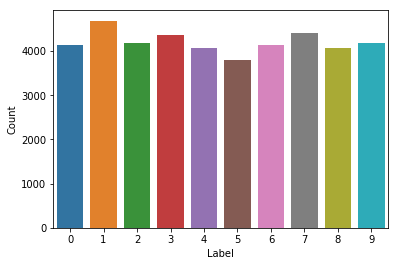

In [9]:
_ = sns.countplot(digits_data.label)
_ = plt.xlabel('Label')
_ = plt.ylabel('Count')

It can be seen that the predicted variable Label is almost uniformly distributed among the classes.

It will be counter-productive to analyse the pixel columns since there are 784 of them. Proceeding to model building now.

### Test-Train Split

In [10]:
# splitting into X and y
X = digits_data.drop("label", axis = 1)
y = digits_data['label']

# scaling the features
X_scaled = scale(X)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.8, random_state = 101)

C:\Users\H253015\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  


### Model building

Building a a basic linear model first

In [13]:
model_linear = SVC(kernel='linear')
model_linear.fit(X_train, y_train)

# predict
y_pred = model_linear.predict(X_test)

In [26]:
# confusion matrix and accuracy

# accuracy
print("accuracy:", metrics.accuracy_score(y_true=y_test, y_pred=y_pred), "\n")

# cm
# The confusion matrix can be printed using the below statement.
print(metrics.confusion_matrix(y_true=y_test, y_pred=y_pred))

accuracy: 0.9396428571428571 

[[3195    0   19    5    4   11   32    4   14    1]
 [   0 3689   23   12    8    3    7    6    8    4]
 [  15   15 3144   29   31    5   18   37   43    6]
 [   5    8   92 3191    5   73    6   31   43   21]
 [   3    7   57    1 3099    9   19   21    7   67]
 [  15   10   37   66   16 2776   53   15   32   19]
 [  19    5   46    1   12   31 3149    2   12    0]
 [   6   21   66   11   25    3    0 3285    3   84]
 [  14   24   40   63   14   62   22   19 2996   18]
 [  12   10   38   40   80    6    0   97   24 3048]]


An accuracy of 91% is given by the linear model. Proceeding with a non-linear model.

In [15]:
# non-linear model
# using rbf kernel, C=1, default value of gamma

# model
non_linear_model = SVC(kernel='rbf')

# fit
non_linear_model.fit(X_train, y_train)

# predict
y_pred = non_linear_model.predict(X_test)

# accuracy
print("accuracy:", metrics.accuracy_score(y_true=y_test, y_pred=y_pred), "\n")

C:\Users\H253015\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


accuracy: 0.9396428571428571 



It can be seen that the accuracy has increased to ~94% on using a non-linear model with default hyper-parameters. Proceeding with a non-linear model with hyper-parameter tuning.

In [16]:
# creating a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 101)

# specify range of hyperparameters
# Set the parameters by cross-validation
hyper_params = [ {'gamma': [1e-2, 1e-3],
                     'C': [1, 10, 100, 1000]}]


# specify model
model = SVC(kernel="rbf")

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = model, 
                        param_grid = hyper_params, 
                        scoring= 'accuracy', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 70.6min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=101, shuffle=True),
       error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'gamma': [0.01, 0.001], 'C': [1, 10, 100, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=1)

In [17]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,94.172521,1.300844,12.013789,0.757236,1,0.01,"{'C': 1, 'gamma': 0.01}",0.752381,0.750595,0.747024,...,0.741310,0.010784,8,1.000000,0.999851,0.999851,1.000000,1.000000,0.999940,0.000073
1,23.538641,0.272220,6.686505,0.066297,1,0.001,"{'C': 1, 'gamma': 0.001}",0.935119,0.926786,0.935119,...,0.930833,0.004216,4,0.972321,0.971429,0.971429,0.972173,0.973214,0.972113,0.000663
2,96.047651,1.237789,11.355425,0.058040,10,0.01,"{'C': 10, 'gamma': 0.01}",0.766071,0.772619,0.765476,...,0.760476,0.009705,5,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
3,20.351133,0.470801,6.163142,0.205818,10,0.001,"{'C': 10, 'gamma': 0.001}",0.941071,0.938690,0.945833,...,0.939405,0.003865,1,0.999405,0.999554,0.999405,0.999107,0.999256,0.999345,0.000152
4,105.619704,6.794284,12.224989,0.448324,100,0.01,"{'C': 100, 'gamma': 0.01}",0.766071,0.772619,0.765476,...,0.760476,0.009705,5,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
5,20.710367,0.441886,6.325126,0.177861,100,0.001,"{'C': 100, 'gamma': 0.001}",0.939881,0.936905,0.946429,...,0.939286,0.003783,2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
6,100.211719,1.340923,11.835238,0.285552,1000,0.01,"{'C': 1000, 'gamma': 0.01}",0.766071,0.772619,0.765476,...,0.760476,0.009705,5,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
7,21.134921,0.345954,6.386306,0.055034,1000,0.001,"{'C': 1000, 'gamma': 0.001}",0.939881,0.936905,0.946429,...,0.939286,0.003783,2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


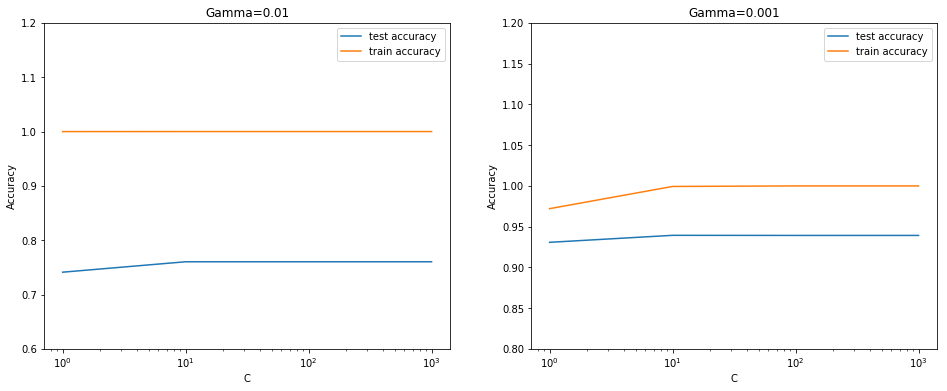

In [24]:
cv_results['param_C'] = cv_results['param_C'].astype('int')

# # plotting
plt.figure(figsize=(16,6))

# subplot 1/2
plt.subplot(121)
gamma_01 = cv_results[cv_results['param_gamma']==0.01]

plt.plot(gamma_01["param_C"], gamma_01["mean_test_score"])
plt.plot(gamma_01["param_C"], gamma_01["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.01")
plt.ylim([0.60, 1.2])
plt.legend(['test accuracy', 'train accuracy'], loc='upper right')
plt.xscale('log')

# subplot 2/2
plt.subplot(122)
gamma_001 = cv_results[cv_results['param_gamma']==0.001]

plt.plot(gamma_001["param_C"], gamma_001["mean_test_score"])
plt.plot(gamma_001["param_C"], gamma_001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.001")
plt.ylim([0.80, 1.2])
plt.legend(['test accuracy', 'train accuracy'], loc='upper right')
plt.xscale('log')

In [25]:
# printing the optimal accuracy score and hyperparameters
best_score = model_cv.best_score_
best_hyperparams = model_cv.best_params_

print("The best test score is {0} corresponding to hyperparameters {1}".format(best_score, best_hyperparams))

The best test score is 0.9394047619047619 corresponding to hyperparameters {'C': 10, 'gamma': 0.001}


In [27]:
# Running SVM with the parameters found above
# Model
tuned_model = SVC(kernel='rbf', C=10, gamma=0.001)
# Fit
tuned_model.fit(X_train, y_train)
# Predict
y_pred = non_linear_model.predict(X_test)

In [56]:
 class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
print(metrics.classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3285
           1       0.97      0.98      0.98      3760
           2       0.88      0.94      0.91      3343
           3       0.93      0.92      0.93      3475
           4       0.94      0.94      0.94      3290
           5       0.93      0.91      0.92      3039
           6       0.95      0.96      0.96      3277
           7       0.93      0.94      0.94      3504
           8       0.94      0.92      0.93      3272
           9       0.93      0.91      0.92      3355

   micro avg       0.94      0.94      0.94     33600
   macro avg       0.94      0.94      0.94     33600
weighted avg       0.94      0.94      0.94     33600



In [58]:
# Confusion Matrix
matrix = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)
matrix

array([[3195,    0,   19,    5,    4,   11,   32,    4,   14,    1],
       [   0, 3689,   23,   12,    8,    3,    7,    6,    8,    4],
       [  15,   15, 3144,   29,   31,    5,   18,   37,   43,    6],
       [   5,    8,   92, 3191,    5,   73,    6,   31,   43,   21],
       [   3,    7,   57,    1, 3099,    9,   19,   21,    7,   67],
       [  15,   10,   37,   66,   16, 2776,   53,   15,   32,   19],
       [  19,    5,   46,    1,   12,   31, 3149,    2,   12,    0],
       [   6,   21,   66,   11,   25,    3,    0, 3285,    3,   84],
       [  14,   24,   40,   63,   14,   62,   22,   19, 2996,   18],
       [  12,   10,   38,   40,   80,    6,    0,   97,   24, 3048]],
      dtype=int64)

In [64]:
class_Accuracy_df = pd.DataFrame({'Class':digits, 'Accuracy':100*matrix.diagonal()/matrix.sum(axis=1)})
class_Accuracy_df['Accuracy'] = class_Accuracy_df.Accuracy.apply(lambda x : round(x,2))
class_Accuracy_df

,Class,Accuracy
0,0,97.26
1,1,98.11
2,2,94.05
3,3,91.83
4,4,94.19
5,5,91.35
6,6,96.09
7,7,93.75
8,8,91.56
9,9,90.85
